## Adding sub-annual time slices and storage
This script adds seasonality and storage to Maldives model/scenario
For more information on seasonality, please refer to [this tutorial](<https://github.com/iiasa/message_ix/blob/master/tutorial/westeros/westeros_seasonality.ipynb>)

In [47]:
# Importing required packages
import itertools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp
import message_ix

from message_ix.utils import make_df

In [48]:
mp = ixmp.Platform()

In [49]:
# Loading a baseline scenario
model = "Maldives energy model"
base = message_ix.Scenario(mp, model=model, scenario='baseline')

# Cloning to a new scenario for editing
scen = base.clone(model, 'time-slice', 
                  keep_solution=False)

# Checking out the scenario for editing
scen.check_out()

In [50]:
scen.init_var("STORAGE", idx_sets = ['node', 'technology', 'level', 'commodity', 'year', 'time'])
scen.init_var("STORAGE_CHARGE", idx_sets = ['node', 'technology', 'level', 'commodity', 'year', 'time'])
scen.init_var("STORAGE_INIT", idx_sets = ['node', 'technology', 'level', 'commodity', 'year', 'time'])

### 1. Representing sub-annual time slices
#### 1.1. Modifying sets

In [51]:
# Adding sub-annual time steps
time_steps = ['day', 'night']
scen.add_set('time', time_steps)

In [52]:
# Defining a new temporal level
time_level = 'daylight'
scen.add_set('lvl_temporal', time_level)

# Adding temporal hierarchy
for t in time_steps:
    scen.add_set('map_temporal_hierarchy', [time_level, t, 'year'])

#### 1.2 Modifying parameters

In [53]:
# Adding duration time
for t in time_steps:
    scen.add_par('duration_time', [t], 1/len(time_steps), '-')

We define a function for manupulating the data of parameters for each sub-annual time slice. This is used for changing demand, input/output, var_cost, etc.

In [54]:
# A function for adding sub-annual data to a parameter
def yearly_to_season(scen, parameter, data, filters=None):
    if filters:
        old = scen.par(parameter, filters)
    else:
        old = scen.par(parameter)
    scen.remove_par(parameter, old)
    
    # Finding "time" related indexes and updating the data
    time_idx = [x for x in scen.idx_names(parameter) if 'time' in x]
    for h in data.keys():
        new = old.copy()
        for time in time_idx:
            new[time] = h
        new['value'] = data[h] * old['value']
        scen.add_par(parameter, new)

In [55]:
# Modifying demand for each time slice
# Electricity demand
demand_data = {'day': 0.4, 'night': 0.60}
filters = {'commodity': 'electricity'}
yearly_to_season(scen, 'demand', demand_data) #added =None

# Here, I just divid them the yearly demand for day and night equally
demand_data = {'day': 0.50, 'night': 0.50}
filters = {'commodity': ['cooling', 'freshwater', 'other_electricity']}
yearly_to_season(scen, 'demand', demand_data) #added =None

In [56]:
# Modifying input and output parameters for each time slice
# Output of solar PV at night zero
pv_data = {'day': 1, 'night': 0}
pv_filters = {'technology': 'solar_pv_ppl'}
yearly_to_season(scen, 'output', pv_data, pv_filters)

# Output of other technologies
fixed_data = {'day': 1, 'night': 1}
other_filters = {'technology': ['oil_ppl', 'battery_ppl', 'ac', 'ro_pl', 'swac', 'dscd', 'appliances']}
yearly_to_season(scen, 'output', fixed_data, other_filters)

# Input of all technologies
yearly_to_season(scen, 'input', fixed_data)

In [57]:
# Modifying capacity factor
# Yearly capacity factor of solar_pv in the baseline scenario
cf_solar = scen.par('capacity_factor', {'technology': 'solar_pv_ppl'})['value'].mean()

# Converting yearly capacity factor to day-night (multiplying CF by 2 for day)
cf_data = {'day': 2, 'night': 0} 
yearly_to_season(scen, 'capacity_factor', cf_data, pv_filters)

# Capacity factor of other technologies remains unchanged in each time slice
yearly_to_season(scen, 'capacity_factor', fixed_data, other_filters)


In [58]:
# Modifying initial penetration rates for each time slice
half_data = {'day': 0.5, 'night': 0.5} 
yearly_to_season(scen, 'initial_activity_up', half_data)

In [59]:
# Modifying historical activity 
hist_data = {'day': 1, 'night': 0}
yearly_to_season(scen, 'historical_activity', hist_data, pv_filters)
# For others divide equally between day and night
hist_data = {'day': 0.5, 'night': 0.5}
yearly_to_season(scen, 'historical_activity', hist_data, other_filters)

In [60]:
# Modifying variable cost
yearly_to_season(scen, 'var_cost', fixed_data)

In [61]:
# Removing output of solar_pv at night

In [62]:
scen.commit(comment='introducing seasonality')
scen.set_as_default()

In [63]:
scen.solve()

### 2. Representing storage

In [64]:
# Cloning to a new scenario for adding storage
sc = scen.clone(model, 'storage', 'storage_solution', keep_solution=False)

# Checking out the scenario for editing
sc.check_out()

#### 2.1 Configuring storage sets

In [65]:
# Adding level of storage
sc.add_set('level', 'store')

# Adding storage technologies (based on the notation of: reservoir, charger, and discharger)
sc.add_set('technology', ['battery_stor', 'dummay', 'battery_ppl'])

# Adding a storage commodity
sc.add_set('commodity', ['dummay'])

# Specifying storage reservoir technology
sc.add_set('storage_tec', 'battery_stor')

# Specifying storage level
sc.add_set('level_storage', 'store')

# Adding mapping for storage and charger/discharger technologies
for tec in ['dummay', 'battery_ppl']:
    sc.add_set('map_tec_storage', ['Maldives', tec, 'battery_stor', 'store',
                                     'electricity'])

#### 2.2. Configuring storage parameters

In [66]:
# Adding the order of time slices
sc.add_par('time_order', ['daylight', 'day'], 1, '-')
sc.add_par('time_order', ['daylight', 'night'], 2, '-')

In [67]:
# Adding output and input for storage technologies
# Loading the output of battery
data = sc.par('output', {'technology': 'battery_ppl'})

# Order of data: ['commodity', 'level']
output_spec = {'battery_stor': ['dummay', 'final'],
               'dummay': ['electricity', 'store'],
               }
for tec, item in output_spec.items():
    data['technology'] = tec
    data['commodity'] = item[0]
    data['level'] = item[1]
    sc.add_par('output', data)

# Configuring input parameter
data = data.rename({'node_dest': 'node_origin', 'time_dest': 'time_origin'}, axis=1)
input_spec = {'battery_stor': ['dummay', 'final'],
              'dummay': ['electricity', 'final'],
              'battery_ppl': ['electricity', 'store'],
              }

for tec, item in input_spec.items():
    data['technology'] = tec
    data['commodity'] = item[0]
    data['level'] = item[1]
    sc.add_par('input', data)


In [68]:
# Adding storage self-discharge (as %) and initial content (assuming 3% loss of battery charge between day and night (6%/day))
for year, h in itertools.product(set(sc.set('year')), time_steps):
    storage_spec = ['Maldives', 'battery_stor', 'store', 'dummay', year, h]
    sc.add_par('storage_self_discharge', storage_spec, 0.03, '%')

    # Adding initial content of storage (optional)
    initial_value = 0
    storage_spec = ['Maldives', 'battery_stor', 'store', 'dummay', year, 'day']
    sc.add_par('storage_initial', storage_spec, initial_value, 'MWa')

#### Committing and solving

In [69]:
sc.commit('storage setup added')
sc.solve(var_list=['STORAGE', 'STORAGE_CHARGE', 'STORAGE_INIT'])

In [70]:
# The battery doesn't work as it is expensive with PV (oil_ppl supplies all demand)
sc.var('STORAGE')

,node,technology,level,commodity,year,time,lvl,mrg
0,Maldives,battery_stor,store,electricity,2020,year,0.0,0.000000e+00
1,Maldives,battery_stor,store,electricity,2020,day,0.0,4.940656e-324
2,Maldives,battery_stor,store,electricity,2020,night,0.0,0.000000e+00
3,Maldives,battery_stor,store,electricity,2025,year,0.0,0.000000e+00
4,Maldives,battery_stor,store,electricity,2025,day,0.0,4.940656e-324
5,Maldives,battery_stor,store,electricity,2025,night,0.0,0.000000e+00
6,Maldives,battery_stor,store,electricity,2030,year,0.0,0.000000e+00
7,Maldives,battery_stor,store,electricity,2030,day,0.0,0.000000e+00
8,Maldives,battery_stor,store,electricity,2030,night,0.0,4.940656e-324
9,Maldives,battery_stor,store,electricity,2035,year,0.0,0.000000e+00


In [89]:
# A new scenario with lower cost of battery or bound on oil
sc_lo = sc.clone(scenario='storage-oil-bound', keep_solution=False)
sc_lo.check_out()

In [90]:
# Reducing inv_cost
for parname in ['inv_cost']:
    df = sc_lo.par(parname, {'technology': ['battery_ppl', 'swac']})
    df['value'] *= .5
    sc_lo.add_par(parname, df)

In [91]:
# bound on activity of oil at night
base_act = {
    'node_loc': 'Maldives',
    'year_act': list(set(sc_lo.set('year'))),
    'mode': 'standard',
    'time': 'night',
    'unit': 'MWa',
}

new_activity = {'oil_ppl': 100}

for tec, val in new_activity.items():
    df = make_df(base_act, technology=tec, value=val)
    sc_lo.add_par('bound_activity_up', df)

In [92]:
sc_lo.commit('')
sc_lo.solve(var_list=['STORAGE', 'STORAGE_CHARGE', 'STORAGE_INIT'])

In [93]:
sc_lo.var('STORAGE')

,node,technology,level,commodity,year,time,lvl,mrg
0,Maldives,battery_stor,store,electricity,2020,year,0.0,0.000000e+00
1,Maldives,battery_stor,store,electricity,2020,day,90294087.8,0.000000e+00
2,Maldives,battery_stor,store,electricity,2020,night,0.0,4.940656e-324
3,Maldives,battery_stor,store,electricity,2025,year,0.0,0.000000e+00
4,Maldives,battery_stor,store,electricity,2025,day,142016001.2,0.000000e+00
5,Maldives,battery_stor,store,electricity,2025,night,0.0,4.940656e-324
6,Maldives,battery_stor,store,electricity,2030,year,0.0,0.000000e+00
7,Maldives,battery_stor,store,electricity,2030,day,156042282.8,0.000000e+00
8,Maldives,battery_stor,store,electricity,2030,night,0.0,4.940656e-324
9,Maldives,battery_stor,store,electricity,2035,year,0.0,0.000000e+00


In [94]:
import pyam
from ixmp.reporting import configure
from message_ix.reporting import Reporter
import os
import matplotlib.pyplot as plt
configure(units={'replace': {'-': 'MWa'}})

In [95]:
rep = Reporter.from_scenario(sc_lo)

In [96]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

nl        t     ya    c        l     
Maldives  ac    2020  cooling  useful         0.0
                2025  cooling  useful         0.0
                2030  cooling  useful         0.0
                2035  cooling  useful         0.0
                2040  cooling  useful         0.0
          dscd  2020  cooling  useful    170197.2
                2025  cooling  useful    267688.8
                2030  cooling  useful    294127.2
                2035  cooling  useful    300736.8
                2040  cooling  useful    304041.6
          swac  2020  cooling  useful         0.0
                2025  cooling  useful         0.0
                2030  cooling  useful         0.0
                2035  cooling  useful         0.0
                2040  cooling  useful         0.0
dtype: float64

In [97]:
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

nl        t             ya    c            l    
Maldives  battery_ppl   2020  electricity  final    9.029409e+07
                        2025  electricity  final    1.420160e+08
                        2030  electricity  final    1.560423e+08
                        2035  electricity  final    1.595489e+08
                        2040  electricity  final    1.613021e+08
          dummay        2020  electricity  store    9.029409e+07
                        2025  electricity  store    1.420160e+08
                        2030  electricity  store    1.560423e+08
                        2035  electricity  store    1.595489e+08
                        2040  electricity  store    1.613021e+08
          oil_ppl       2020  electricity  final    1.797586e+08
                        2025  electricity  final    1.797586e+08
                        2030  electricity  final    1.797586e+08
                        2035  electricity  final    1.797586e+08
                        2040  electricity

In [98]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = elec.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

nl        t      ya    c           l     
Maldives  dscd   2020  freshwater  useful    8.509860e+02
                 2025  freshwater  useful    1.338444e+03
                 2030  freshwater  useful    1.470636e+03
                 2035  freshwater  useful    1.503684e+03
                 2040  freshwater  useful    1.520208e+03
          ro_pl  2020  freshwater  useful    1.804475e+07
                 2025  freshwater  useful    2.838106e+07
                 2030  freshwater  useful    3.118413e+07
                 2035  freshwater  useful    3.188490e+07
                 2040  freshwater  useful    3.223528e+07
dtype: float64

In [99]:
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=elec,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_elec = rep.get(new_key)
df_elec.data.unit = 'MWa'
df_elec.to_csv('electricity_stor.csv')

message_ix.reporting.pyam - WARNING: Extra columns ['c'] when converting None to IAMC format


In [100]:
elec_gen = pd.read_csv("electricity_stor.csv")
elec_gen.columns 

Index(['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'C', '2020', '2025',
       '2030', '2035', '2040'],
      dtype='object')

In [101]:
# Loading data from csv into a pyam format
elec_gen = pyam.IamDataFrame(data='electricity_stor.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
elec_gen.data

pyam.core - INFO: Reading file electricity_stor.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|battery_ppl,MWa,2020,electricity,9.029409e+07
1,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|battery_ppl,MWa,2025,electricity,1.420160e+08
2,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|battery_ppl,MWa,2030,electricity,1.560423e+08
3,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|battery_ppl,MWa,2035,electricity,1.595489e+08
4,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|battery_ppl,MWa,2040,electricity,1.613021e+08
5,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|oil_ppl,MWa,2020,electricity,1.797586e+08
6,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|oil_ppl,MWa,2025,electricity,1.797586e+08
7,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|oil_ppl,MWa,2030,electricity,1.797586e+08
8,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|oil_ppl,MWa,2035,electricity,1.797586e+08
9,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|final|oil_ppl,MWa,2040,electricity,1.797586e+08


<AxesSubplot:title={'center':'Electricity Generation by technology'}, xlabel='MWa', ylabel='Year'>

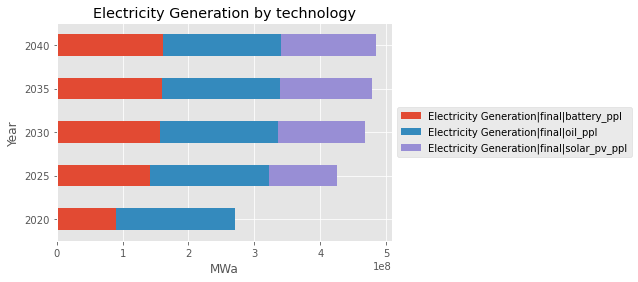

In [102]:
plotyrs = [x for x in set(sc_lo.set('year')) if x >= sc_lo.firstmodelyear]
elec = elec_gen.filter(region=['Maldives'], variable='Electricity Generation|final|*', year=plotyrs)
elec.plot.bar(stacked=True, orient='h',
              title='Electricity Generation by technology')

In [105]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = wat.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=wat,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_wat = rep.get(new_key)
df_wat.data.unit = 'm^3'
df_wat.to_csv('freshwater_stor.csv')

message_ix.reporting.pyam - WARNING: Extra columns ['c'] when converting None to IAMC format


In [106]:
wat_gen = pd.read_csv("freshwater_stor.csv")

In [107]:
# Loading data from csv into a pyam format
wat_gen = pyam.IamDataFrame(data='freshwater_stor.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
wat_gen.data

pyam.core - INFO: Reading file freshwater_stor.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2020,freshwater,8.509860e+02
1,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2025,freshwater,1.338444e+03
2,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2030,freshwater,1.470636e+03
3,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2035,freshwater,1.503684e+03
4,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2040,freshwater,1.520208e+03
5,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2020,freshwater,1.804475e+07
6,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2025,freshwater,2.838106e+07
7,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2030,freshwater,3.118413e+07
8,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2035,freshwater,3.188490e+07
9,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2040,freshwater,3.223528e+07


<AxesSubplot:title={'center':'model: Maldives energy model scenario: storage-oil-bound region: Maldives'}, xlabel='Year', ylabel='a * m ** 3'>

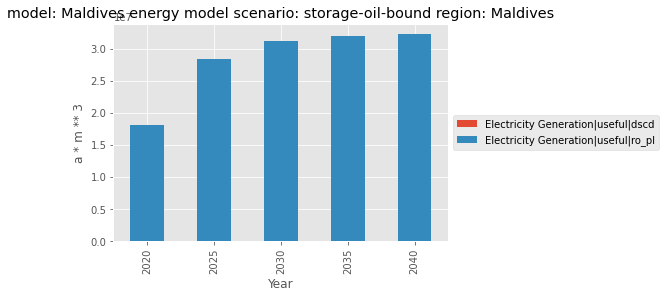

In [108]:
wat = wat_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
wat.plot.bar(stacked=True)

In [109]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=cool,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_cool = rep.get(new_key)
df_cool.data.unit = 'MWa'
df_cool.to_csv('cooling_stor.csv')

message_ix.reporting.pyam - WARNING: Extra columns ['c'] when converting None to IAMC format


In [110]:
cool_gen = pd.read_csv("cooling_stor.csv")
cool_gen.columns 

Index(['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'C', '2020', '2025',
       '2030', '2035', '2040'],
      dtype='object')

In [111]:
# Loading data from csv into a pyam format
cool_gen = pyam.IamDataFrame(data='cooling_stor.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
cool_gen.data

pyam.core - INFO: Reading file cooling_stor.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ac,MWta,2020,cooling,0.0
1,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ac,MWta,2025,cooling,0.0
2,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ac,MWta,2030,cooling,0.0
3,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ac,MWta,2035,cooling,0.0
4,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|ac,MWta,2040,cooling,0.0
5,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,MWta,2020,cooling,170197.2
6,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,MWta,2025,cooling,267688.8
7,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,MWta,2030,cooling,294127.2
8,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,MWta,2035,cooling,300736.8
9,Maldives energy model,storage-oil-bound,Maldives,Electricity Generation|useful|dscd,MWta,2040,cooling,304041.6


<AxesSubplot:title={'center':'model: Maldives energy model scenario: storage-oil-bound region: Maldives'}, xlabel='Year', ylabel='MWta'>

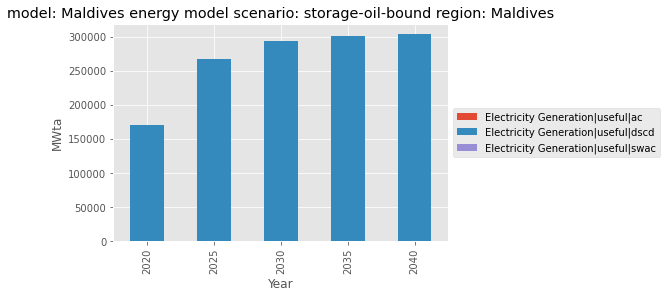

In [112]:
cool = cool_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
cool.plot.bar(stacked=True)

In [113]:
mp.close_db()